Thi notebook will set up a mutlilayer perceptron. More specifically a perceptron with two hidden layers

# Set up

- Predefine constants
    - Initialize the weights and thresholds
    - Select amount of neurons in hidden layers
    - Select learning rate
- Visulize the training data and validation data

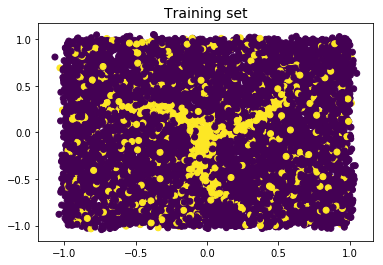

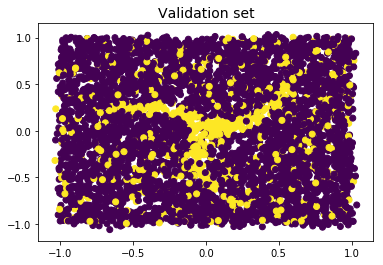

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np

np.random.seed(seed=2019)



################## Load the data and visualize the data ###################
df = pd.read_csv('training_set.csv')
values = df.values

X_train = np.copy(values[:,0:2])
y_train = np.copy(values[:,2])

plt.scatter(X_train[:,0], X_train[:,1], 
            c = list(map(lambda x: 0 if x==-1 else 1 , y_train)))
plt.title('Training set', size= 14)
plt.show()


df = pd.read_csv('validation_set.csv')
values = df.values
X_val = np.copy(values[:,0:2])
y_val = np.copy(values[:,2])

plt.scatter(X_val[:,0], X_val[:,1], 
            c = list(map(lambda x: 0 if x==-1 else 1 , y_val)))
plt.title('Validation set', size = 14)
plt.show()






################# Pre-define the constants ##############################
M_1 = 10
M_2 = 10
eta = 0.01


#Initialize the weights with Gaussian distribution
# The key in the dictionary represents the layer
Weights = {1: np.asarray(np.random.normal(0, 1, M_1*2).reshape(M_1,2)),
           2: np.asarray(np.random.normal(0, 1, M_2*M_1).reshape(M_2,M_1)),
           3: np.asarray(np.random.normal(0, 1, 1*M_2).reshape(1,M_2)),
          }



Errors = {1:np.zeros((M_1)),
          2:np.zeros((M_2)),
          3:np.zeros((1)),
          }


Neurons = {0:np.zeros((2)),
           1:np.zeros((M_1)),
           2:np.zeros((M_2)),
           3:np.zeros((1)),
          }


Thresholds = {1:np.zeros((M_1)),
              2:np.zeros((M_2)),
              3:np.zeros((1)),
             }


# Sequential training (stochastic gradient descent)

Notations

- $V_i$ be the state of neuron $i$
- $w_{ij}^{(l)}$ be the weights in layer $l$ between neuron $i$ and $j$ where $i$ is the layer above.
- $\theta_i^{(l)}$ be the threshold of neuron $i$ in layer $l$
- $b_i$ be the local field of neuron $i$
- $\delta_i^{(l)}$ be the errors of neuron $i$ in layer $l$


Pseudo algorithms or stochastic gradietn descent

- For a number of training
    - Choose a random sample and apply it to input layer
    - For each layer $l = 1,...,L$
        - Propagate forward $V_k^{l} \leftarrow g\Big(  \sum_j w_{kj}^{(l)}V_{j}^{(l-1)} - \theta_{k}^{(l)} \Big)$
    - Compute errors for output layer $\delta_j^{(L)} \leftarrow g'(b_i^{(L)})(t_i - V_i^{(L)})$
    - For each layer $l = L,...,2$
        - Propagate backward the error $\delta_j^{(l-1)} \leftarrow \sum_i \delta_i^{(l)} w_{ij}^{(l)} g'(b_j^{(l-1)})$
    - For each layer $l=1,...,L$
        - update weights and thresholds: $w_{ij}^{(l)} \leftarrow w_{ij}^{(l)} + \eta \delta_i^{(l)}V_j^{(l-1)}$ and  $\theta_i^{(l)} \leftarrow \theta_i^{(l)} - \eta \delta_i^{(l)}$

In [2]:
#np.arctanh([0, -0.5])
import time

"""
This function performs stochastic gradient descent on one pattern
"""
def stochasticGradientDescent(pattern):
    global Weights
    global Thresholds
    global Errors
    global Neurons
    
    #Feed the pattern to the inputs
    Neurons[0][0] = X_train[pattern,0]
    Neurons[0][1] = X_train[pattern,1]
    
    #Propgate forward each layer
    for layer in range(1,4):                   
        for k in range(len(Neurons[layer])):        
            Neurons[layer][k] = np.tanh(np.dot(Weights[layer][k],
                                        Neurons[layer-1].T) - Thresholds[layer][k])
    
    # Compute the errors for outputlayer
    b_output = np.dot(Weights[3],Neurons[2].T) - Thresholds[3][0]
    Errors[3]= (1-np.square(np.tanh(b_output)))*(y_train[pattern] - Neurons[3])

    #propagate backward in each layer 
    for layer in range(3,1,-1):     
        for j in range(len(Neurons[layer-1])):
            b_j = np.dot(Weights[layer-1][j],
                                Neurons[layer-2].T) - Thresholds[layer-1][j]
                        
            Errors[layer-1][j] = np.dot(Errors[layer],
                                        Weights[layer][:,j])*(1-np.square(np.tanh(b_j)))
    
    #Update the weights and thresholds
    for layer in range(1,4):     
        for i in range(len(Neurons[layer])):
            for j in range(len(Neurons[layer-1])):
                Weights[layer][i][j] +=  eta*Errors[layer][i]*Neurons[layer-1][j]
            Thresholds[layer][i] -= eta*Errors[layer][i]
    



# Training progress

0% [#######                       ] 100% | ETA: 00:07:39

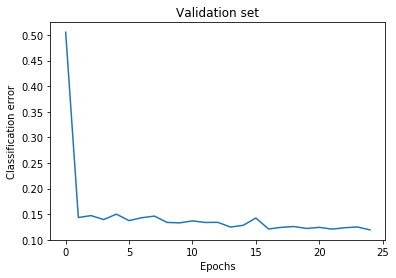

In [3]:
#print(Neurons[0][1])
from matplotlib  import pyplot as plt
import pyprind

ValErrors= []
trainErrors=[]
epochs= []
for updates in pyprind.prog_bar(range(1000000)): # Perform number of updates
    
    if(updates%10000==0):
        epochs.append(updates)
        
        predictions = []
        for i in range(len(X_val)):
            Neurons[0][0] = X_val[i,0]
            Neurons[0][1] = X_val[i,1]
    
            #Propgate forward each layer
            for layer in range(1,4):                   
                for k in range(len(Neurons[layer])):
                    b_k = np.dot(Weights[layer][k],
                                 Neurons[layer-1].T) - Thresholds[layer][k]
                    Neurons[layer][k] = np.tanh(b_k)
            
            if(np.sign(Neurons[3])==0):
                predictions.append(1)
            else:
                predictions.append(np.sign(Neurons[3])[0])
        
        ValErrors.append((np.sum(np.absolute(predictions - y_val))/(2*len(X_val))))
        if(ValErrors[len(ValErrors)-1]<0.12):
            break;

    
    stochasticGradientDescent(np.random.choice(len(X_train),1))
        
        

        
        
################ Plotting ######################################
plt.plot(np.arange(len(ValErrors)),ValErrors)
plt.title('Validation set')
plt.xlabel('Epochs')
plt.ylabel('Classification error')
plt.show()
    

    

In [4]:
print(ValErrors[-3:])

np.savetxt('w1.csv', Weights[1], delimiter=',') 
np.savetxt('w2.csv', Weights[2], delimiter=',') 
np.savetxt('w3.csv', Weights[3], delimiter=',') 
np.savetxt('t1.csv', Thresholds[1], delimiter=',') 
np.savetxt('t2.csv', Thresholds[2], delimiter=',') 
np.savetxt('t3.csv', Thresholds[3], delimiter=',') 

[0.1234246849369874, 0.1250250050010002, 0.11922384476895379]
